In [32]:
from lib.models import ResNet
import torch
from torch import nn
from tqdm import tqdm
class CNNLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = ResNet().cuda()
        self.lstm = nn.LSTM(3,32)
        self.fc1 = nn.Linear(32,3)
    def forward(self,x_2d):
        x_2d = x_2d.view(-1,3,1,5000)
        x = torch.Tensor().cuda()
        for t in range(x_2d.size(1)):
            x_i = self.resnet(x_2d[:,t,:,:])
            out,_ = self.lstm(x_i)

            # x = torch.cat([x,x_i.unsqueeze(0)])
        x = self.fc1(out)        
        # return x.view(-1,3,3)
        return x

In [18]:
model = CNNLSTM().cuda()
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
device = 'cuda'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)
train_losses = []
dev_losses = []
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
data_dir = 'w3_small_balanced_normalized'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)

Params:  10534


In [38]:
lossi = []
optimizer = torch.optim.Adam(model.parameters(),lr=3e-6)

# train loop
model.train()
for (X_tr,y_tr) in tqdm(trainloader):
    X_tr,y_tr = X_tr.to(device),y_tr.to(device)
    logits = model(X_tr)
    loss = criterion(logits,y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
model.eval()
loss_dev_total = 0
for (X_dv,y_dv) in tqdm(devloader):
    X_dv,y_dv = X_dv.to(device),y_dv.to(device)
    logits = model(X_dv)
    loss = criterion(logits,y_dv)
    loss_dev_total += loss.item()

print(loss_dev_total/len(devloader))
print(torch.tensor(lossi).mean())

100%|██████████| 135/135 [00:02<00:00, 48.19it/s]

0.3618693374925189
tensor(0.3225)


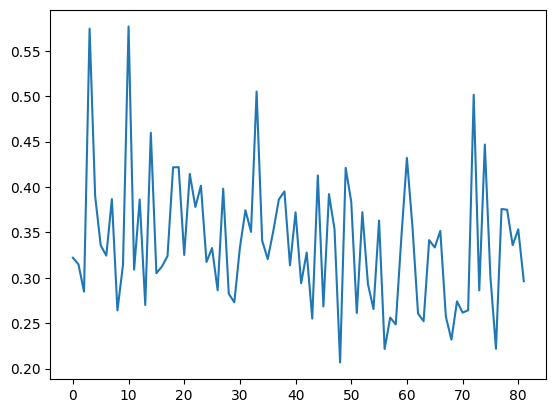

In [37]:
res = 10
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi[:len(lossi)-len(lossi)%res]).view(-1,res)[:,0])